In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# I have a separate preprocessing.ipynb for preprocessing train.csv and test_public.csv
data = pd.read_csv("preprocessed.csv")
publicdata = pd.read_csv("preprocessed_test_public.csv")

In [7]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
class MulPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.1):
        super(MulPerceptron, self).__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.output(x)
        return x

losses = []
val_losses = []

def train_model(model, dataloader, val_dataloader, loss_fn, optimizer, 
                num_epochs=1000, resume_epoch=0):
    global losses, val_losses
    if resume_epoch == 0:
        losses = [0] * num_epochs
        val_losses = []
        model.train()
        model.to(device)
        print(f"going to run for {num_epochs} epochs, with {len(dataloader)} batches each")
    else:
        losses += [0] * num_epochs
    for epoch in range(resume_epoch, num_epochs+resume_epoch):
        # https://pytorch.org/docs/stable/data.html
        total_loss = 0
        for batch, (X, y) in enumerate(dataloader):
            
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
        
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        avg_loss = total_loss / len(dataloader)
        losses[epoch] = np.sqrt(avg_loss)
        if (epoch + 1) % (max(num_epochs // 10, 1)) == 0:
            print(f"epoch {epoch+ 1} of {num_epochs}, RMSE: {np.sqrt(avg_loss):.4f}")
            val_loss = test_model(model, val_dataloader, loss_fn)
            print("validation loss:", val_loss)
            val_losses.append(val_loss)

        
def convert_data(mydata, feature_cols, target_col, max_samples):
    if max_samples < len(mydata):
#         num_samples = min(max_samples, len(data))
        _sampled = mydata.sample(n=max_samples)
    else:
        print("more...")
        _sampled = mydata
    print("samples:", len(_sampled))
#     X = torch.tensor(data[feature_cols].values[:max_samples], dtype=torch.float32)
    _X = torch.tensor(_sampled[feature_cols].values, dtype=torch.float32)
    if target_col == None:
        return _X, None
    _y = torch.tensor(_sampled[target_col].values, dtype=torch.float32).unsqueeze(1)
    return _X, _y

def split_data(_X, _y, test_size=0.2, random_state=2):
    X_TEMP, X_test, y_TEMP, y_test = train_test_split(_X, _y, test_size=test_size, random_state=random_state)
    X_train, X_valid, y_train, y_valid = train_test_split(X_TEMP, y_TEMP, test_size=test_size/(1-test_size), random_state=random_state)
    return X_train, y_train, X_test, y_test, X_valid, y_valid

def test_model(model, dataloader, loss_fn):
    model.to(device)
    model.eval()

    loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model(X)
            loss += loss_fn(y_pred, y).item()

    loss /= len(dataloader)
    
    model.train()
    return np.sqrt(loss)
#     print(f"loss: {np.sqrt(loss):.4f}")

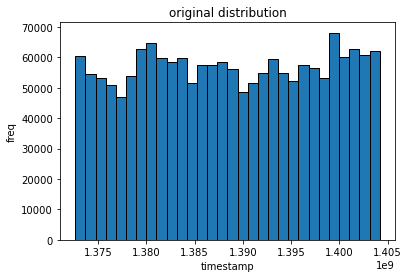

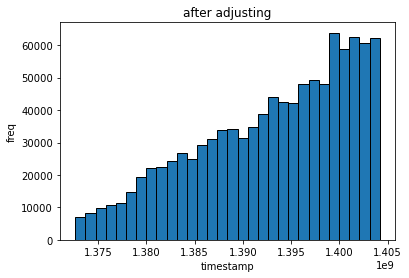

In [8]:
# MORE RECENT DATA IS MORE RELEVANT
data["temp_weight"] = data["TIMESTAMP"].rank() / len(data)
data["temp_rand"] = np.random.random(len(data)) - 0.1
sampled = data[data["temp_rand"] < data["temp_weight"]]
# sampled = data[data["TIMESTAMP"] > data["TIMESTAMP"].mean()]

# MORE RECENT DATA IS MORE RELEVANT
plt.hist(data['TIMESTAMP'], bins=30, edgecolor='black')
plt.xlabel('timestamp')
plt.ylabel('freq')
plt.title('original distribution')
plt.show()

plt.hist(sampled['TIMESTAMP'], bins=30, edgecolor='black')
plt.xlabel('timestamp')
plt.ylabel('freq')
plt.title('after adjusting')
plt.show()

In [9]:
features = [
#             "MON", 
#             "DAY", 
#     "WK",
            "HR",
#     "YR",
            "ORDERED_STAND", 
#             "ORDERED_CALL",
            "ORDERED_TAXI_ID",
#             "TYPE_A", 
#     "TYPE_B", 
#     "TYPE_C",
            "ORDERED_WK", 
    "ORDERED_DAY", 
    "ORDERED_MON",
    "DAY_B",
    "DAY_C",
#             , "START_LAT"
#             , "START_LON"
           ]
target = "LEN"
X, y = convert_data(sampled, features, target, 70000)
X_train, y_train, X_test, y_test, X_valid, y_valid = split_data(X, y, random_state=6)
print(X_train.shape, X_test.shape, X_valid.shape)

samples: 70000
torch.Size([42000, 8]) torch.Size([14000, 8]) torch.Size([14000, 8])


In [10]:
# data = data.sort_values("TIMESTAMP")
sampled.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,...,ORDERED_DAY,ORDERED_MON,TYPE_A,TYPE_B,TYPE_C,START_LOC,START_LAT,START_LON,temp_weight,temp_rand
21,1372637254620000657,A,39233.0,NaN,20000657,1372637254,A,False,"[[-8.660646,41.168574],[-8.661087,41.167926],[...",630,...,-1.654067,-1.329628,1.920861,-0.957131,-0.668182,NaN,NaN,NaN,0.000009,-0.019943
24,1372637658620000596,A,22864.0,NaN,20000596,1372637658,A,False,"[[-8.665686,41.170626],[-8.665677,41.170653],[...",375,...,-1.654067,-1.329628,1.920861,-0.957131,-0.668182,NaN,NaN,NaN,0.000016,-0.054427
25,1372639092620000233,C,NaN,NaN,20000233,1372639092,A,False,"[[-8.632737,41.168295],[-8.6328,41.16825],[-8....",105,...,-1.654067,-1.329628,-0.520600,-0.957131,1.496598,NaN,NaN,NaN,0.000037,-0.018176
41,1372638793620000571,A,2002.0,NaN,20000571,1372638793,A,False,"[[-8.574705,41.142717],[-8.574696,41.142726],[...",600,...,-1.654067,-1.329628,1.920861,-0.957131,-0.668182,NaN,NaN,NaN,0.000035,-0.069717
57,1372638451620000621,A,59594.0,NaN,20000621,1372638451,A,False,"[[-8.602209,41.163372],[-8.601651,41.163759],[...",510,...,-1.654067,-1.329628,1.920861,-0.957131,-0.668182,NaN,NaN,NaN,0.000029,-0.065662


In [11]:
# HYPERPARAMS
# learning_rate = 1e-6
# num_epochs = 10000
# batch_size = 300
# hidden_size = 500
# dropout_rate = 0.1

In [12]:
# train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
# test_dataset = TensorDataset(X_test.to(device), y_test.to(device))
# val_dataset = TensorDataset(X_valid.to(device), y_valid.to(device))
# train_loader = DataLoader(train_dataset, batch_size=batch_size,
#                 shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size,
#                 shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size,
#                 shuffle=True)

In [13]:
# input_size = X_train.shape[1]
# model = MulPerceptron(input_size, hidden_size, dropout_rate=dropout_rate)
# loss_fn = nn.MSELoss()
# # https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.1)

In [14]:
# # TRAIN AND TEST


# # train_model(model, X_train, y_train, num_epochs=num_epochs,
# #             learning_rate=learning_rate, max_samples=100000)
# train_model(model, train_loader, val_loader, loss_fn, optimizer, 
#             num_epochs=num_epochs)

# print("test loss:", test_model(model, test_loader, loss_fn))
# # test_model(model, test_loader, loss_fn)
# # test_model(model, X_test, y_test)

In [17]:
def test_hyperparams(learning_rate = 1e-6, num_epochs = 10000, batch_size = 300, 
                     hidden_size = 500,dropout_rate = 0.1, momentum=0.1, resume_epoch=0, label=None):
    global model
    train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
    test_dataset = TensorDataset(X_test.to(device), y_test.to(device))
    val_dataset = TensorDataset(X_valid.to(device), y_valid.to(device))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    input_size = X_train.shape[1]
    if resume_epoch == 0:
        model = MulPerceptron(input_size, hidden_size, dropout_rate=dropout_rate)
    loss_fn = nn.MSELoss()
    # https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=num_epochs, resume_epoch=resume_epoch)
    print("test loss:", test_model(model, test_loader, loss_fn))
    print("valtest loss:", test_model(model, val_loader, loss_fn))
    plt.plot(range(len(val_losses)), val_losses, label=label)
    xaxis = np.arange(1, len(val_losses)+1) * ((num_epochs+resume_epoch) // 10)
    plt.xticks(np.arange(len(val_losses)), xaxis)
    plt.xlabel("epoch")
    plt.ylabel("RMSE")
    plt.title("val loss vs epoch")
    plt.legend()

going to run for 20 epochs, with 420 batches each
epoch 2 of 20, RMSE: 971.0291
validation loss: 989.324310812327
epoch 4 of 20, RMSE: 969.0610
validation loss: 986.6375865697307
epoch 6 of 20, RMSE: 934.1418
validation loss: 895.0894500890479
epoch 8 of 20, RMSE: 664.6566
validation loss: 679.1523456029188
epoch 10 of 20, RMSE: 656.9462
validation loss: 676.1793170497036
epoch 12 of 20, RMSE: 655.8059
validation loss: 675.0406187762095
epoch 14 of 20, RMSE: 655.5134
validation loss: 674.4608370831687
epoch 16 of 20, RMSE: 655.2837
validation loss: 673.9762088368735
epoch 18 of 20, RMSE: 653.6472
validation loss: 673.7590482346972
epoch 20 of 20, RMSE: 653.6617
validation loss: 673.3827194325357
test loss: 669.9979316832414
valtest loss: 673.3827191424889


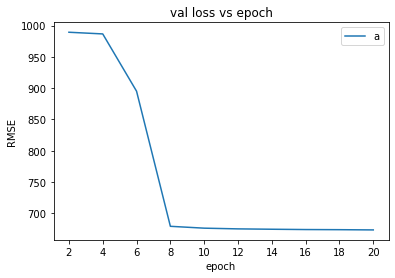

In [18]:
test_hyperparams(1e-7, 20, 100, 500, 0.5, label=str("a"))

In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

506001


In [ ]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
# SAVE MODEL
torch.save(model.state_dict(), "modelweights")

In [ ]:
# LOAD MODEL
# def test_hyperparams(learning_rate = 1e-6, num_epochs = 10000, batch_size = 300, 
#                      hidden_size = 500,dropout_rate = 0.1, momentum=0.1, resume_epoch=0, label=None):
model = MulPerceptron(len(features), 500, dropout_rate=0.5)
model.load_state_dict(torch.load("modelweights"))
model.eval()

In [ ]:
# test_hyperparams(1e-8, 40, 100, 500, 0.5, resume_epoch=20, label=str("a"))

In [ ]:
#test_hyperparams(1e-9, 20, 50, 500, 0.5, resume_epoch=40, label=str("a"))

In [ ]:
# test_hyperparams(1e-9, 200, 100, 500, 0.5, resume_epoch=label=str("a"))

In [ ]:
# test_hyperparams(1e-8, 200, 100, 500, 0.5, resume_epoch=700, label=str("a"))

In [ ]:
# test_hyperparams(1e-9, 200, 100, 500, 0.5, resume_epoch=700, label=str("a"))

In [ ]:
sampled.head()

In [ ]:
len(losses)

In [ ]:
# for lr in [1e-7, 1e-8]:
#     test_hyperparams(lr, 400, 100, 500, 0.5, label=str(lr))
# #     test_hyperparams(1e-6, 200, 300, 500, 0.5, label=str("a"))
# #     test_hyperparams(lr, 300, 200, 500, 0.1, label=str(lr))

In [ ]:
# for hidden_size in [50, 100, 200, 300, 500, 700, 1000]:
#     test_hyperparams(1e-6, 400, 100, hidden_size, 0.5, label=str(hidden_size))
# #     test_hyperparams(1e-5, 300, hidden_size, 500, 0.1, label=str(hidden_size))

In [ ]:
# for batches in [10, 20, 40, 70, 100, 200, 300, 600]:
#     test_hyperparams(1e-6, 400, batches, 500, 0.5, label=str(batches))
#     #test_hyperparams(1e-5, batches, 300, 500, 0.1, label=str(batches))

In [ ]:
# for dropout in [0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8]:
#     test_hyperparams(1e-6, 400, 100, 500, dropout, label=str(dropout))
# #     test_hyperparams(1e-5, 200, 300, 500, dropout, label=str(dropout))

In [ ]:
# test_hyperparams(1e-6, 400, 100, 500, 0.5, label=str(dropout))

In [ ]:
# Sample submission file that is given on kaggle
# df_sample = pd.read_csv("sampleSubmission.csv")

# publicdata["TRAVEL_TIME"] = 716.43
X_public, y_public = convert_data(publicdata, features, None, 100000)
publicdata.head()
# mean(716.43) -> 792.73593
# median(600) -> 784.74219
# publicdata.to_csv("my_pred.csv", index=None)

In [ ]:
# print(len(y_public))
print(len(X_public))
print(len(publicdata))

In [ ]:
X_public = X_public.to(device)

model.eval()

with torch.no_grad():
    y_public = model(X_public)

y_public = y_public.cpu()
publicdata["TRAVEL_TIME"] = y_public
df_submit = publicdata[["TRIP_ID","TRAVEL_TIME"]]

df_submit.to_csv("my_pred.csv", index=None)

# print(y_public)

In [ ]:
# print(y_public)

In [ ]:
# for feat in ["ORDERED_STAND", "ORDERED_CALL", "ORDERED_TAXI_ID"]:
#     print(publicdata[feat].isnull().sum())

# for i in range(len(publicdata)):
#     if np.isnan(publicdata.loc[i, "ORDERED_CALL"]):
#         print(publicdata.loc[i])
#         print("---")